In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rxa
import matplotlib.pyplot as plt
import shapely

from uavsar_pytools.snow_depth_inversion import phase_from_depth, depth_from_phase

In [2]:
ncs_dir = Path('/bsuhome/zacharykeskinen/scratch/data/uavsar/ncs')
ds = xr.open_dataset(ncs_dir.joinpath('final_uv_geom_atm_veg_model_v1.nc')).isel(x = slice(0, -1, 100), y = slice(0, -1, 100))
ds = ds.sortby('time1')

In [3]:
data_dir = Path('/bsuhome/zacharykeskinen/uavsar-validation/data')
insitu_dir = data_dir.joinpath('insitu')
insitu = pd.read_parquet(insitu_dir.joinpath('all_insitu.parq'))
boards = pd.read_parquet(insitu_dir.joinpath('storm_boards.parq'))
boards = gpd.GeoDataFrame(boards, geometry=gpd.points_from_xy(boards.longitude, boards.latitude), crs="EPSG:4326")
# add inc
for i, r in boards.iterrows():
    boards.loc[i, 'inc'] = ds.sel(x = r.geometry.x, y = r.geometry.y, method = 'nearest')['inc'].data.ravel()[0]
    boards.loc[i, 'elev'] = ds.sel(x = r.geometry.x, y = r.geometry.y, method = 'nearest')['dem'].data.ravel()[0]

No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


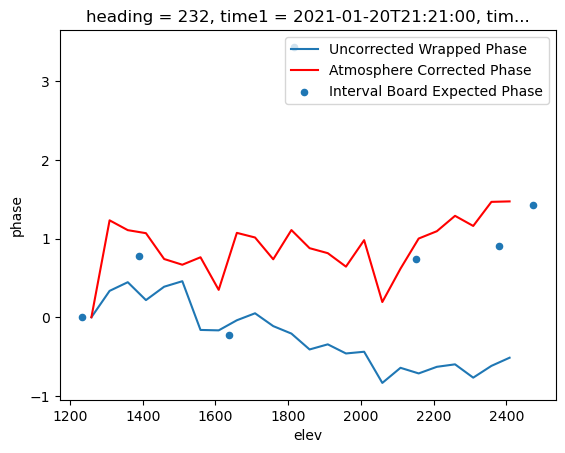

No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


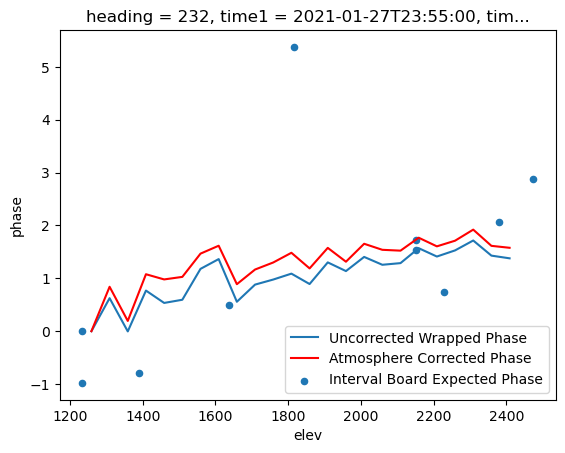

No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


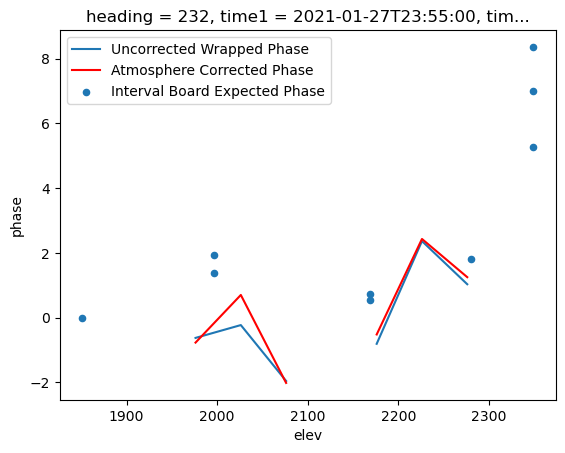

No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


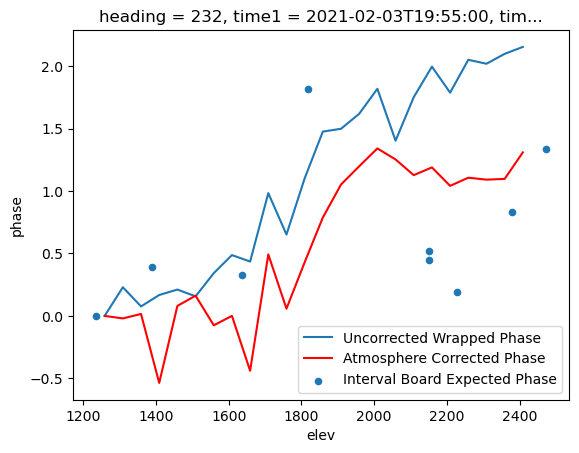

No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


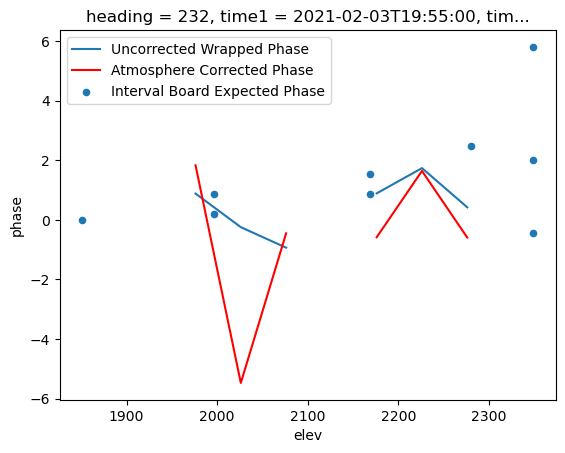

No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


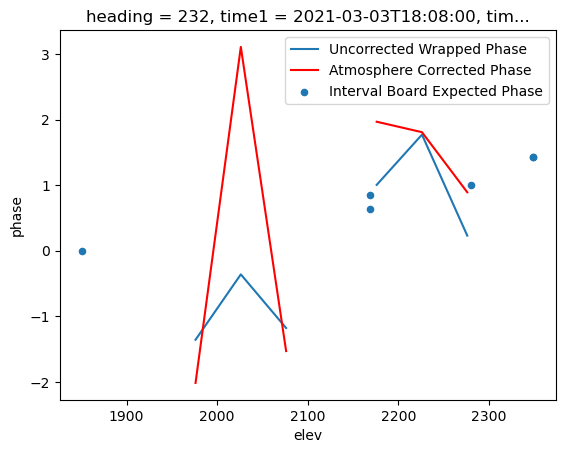

No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


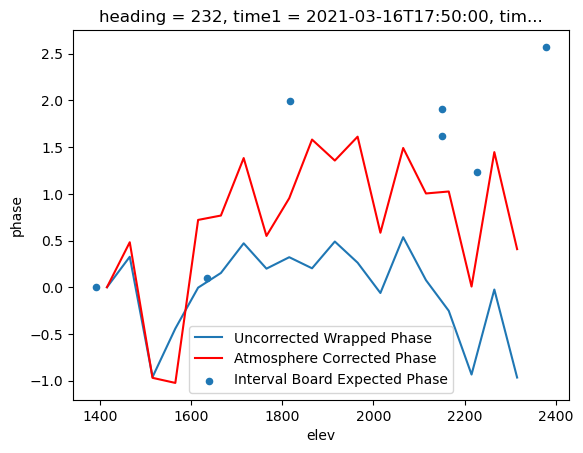

No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


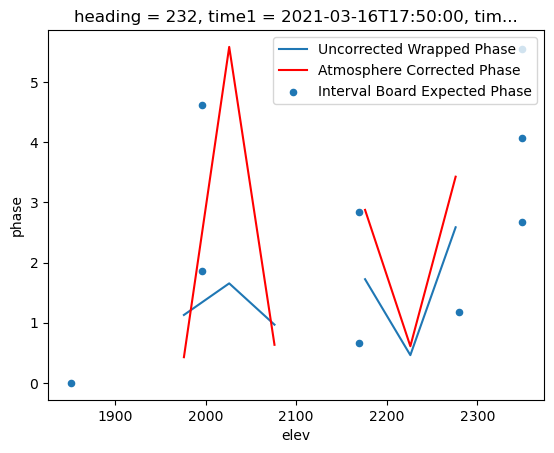

In [4]:
for t1, t2 in zip(ds.time1.data, ds.time2.data):
    flight_boards = boards.loc[(boards.date_t2 <= t2 + pd.Timedelta('2 days')) & (boards.date_t1 >= t1 - pd.Timedelta('2 days')), :].copy()
    for site_id in ['BB','LR', 'MC']:
        flight_boards_site = flight_boards.loc[flight_boards.site.str.contains(site_id), :].copy()
        flight_boards_site = flight_boards_site.dropna(subset=['hn','den','inc'])
        xmin, ymin, xmax, ymax = flight_boards_site.total_bounds
        ds_site = ds.sel(x = slice(xmin, xmax), y = slice(ymax, ymin), time1 = t1)
        # ds_site = ds_site.where((ds_site['cor'] > 0.5))
        if ds_site.x.size > 2 and ds_site.y.size > 2 and len(flight_boards_site) > 4 and ds_site['int_phase'].isnull().sum() != ds_site['int_phase'].size:
            fig, ax = plt.subplots()
            flight_boards_site = flight_boards_site.sort_values('elev')
            board_phase = phase_from_depth(flight_boards_site.hn.values, inc_angle=flight_boards_site.inc.values, density = flight_boards_site.den.values)
            board_phase = board_phase - board_phase[0]
            if sum(np.isnan(board_phase)) > 0:
                break
            flight_boards_site.loc[:, 'phase'] = board_phase
            elev_phase = ds_site.groupby_bins('dem', np.arange(flight_boards_site.elev.min(), flight_boards_site.elev.max(), 50)).mean()
            elev_phase = elev_phase - elev_phase.isel(dem_bins = 0)
            elev_phase['int_phase'].plot(ax = ax, label = 'Uncorrected Wrapped Phase')
            (elev_phase['int_phase'] - elev_phase['delay']).plot(ax = ax, color = 'red', label = 'Atmosphere Corrected Phase')
            flight_boards_site.plot.scatter(x = 'elev', y = 'phase', ax = ax, label = 'Interval Board Expected Phase')
            plt.legend()
            plt.show()